NAME: CHINONSO EMMANUEL OBIEKWE

STUDENT NUMBER: 8877022

In [15]:
!pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os, shutil, pathlib # Importing libraries for file handling and path operations

# Define the original dataset directory (where the full dataset is stored)
original_dir = pathlib.Path("../data/kaggledataset_catsanddogs/train")

# Define the new base directory to store a smaller, reorganized version of the dataset
new_base_dir = pathlib.Path("../data/kagglecatsanddogs_small_test")

#Define a function to create subsets of the dataset (train, validation, test)
# It makes a subset name and a range of image indices to copy for both classes 
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"): # Loop through each class
        dir = new_base_dir / subset_name / category # Create a path 
        os.makedirs(dir) # Ceate the directory if it does't exist
        # Generate a list of filenames to copy
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            # Copy each image files from the original dataset to the new subset directory 
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# Create training set with 1000 images per class
make_subset("train", start_index=0, end_index=1000)
# Create Validation set with 500 images per class
make_subset("validation", start_index=1000, end_index=1500)
# Create test set with 1000 images per class
make_subset("test", start_index=1500, end_index=2500)

Summary
This splits the original dataset of cats and dogs into three subset: training, validation, and testing. For each subset, it copies a specific range of images for both cats and dogs. 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter

1. Obtain the Data: Get the Dogs vs Cats dataset

In [19]:
# This should point to the small dataset of the kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path("../data/kagglecatsanddogs_small_test")

# Load the train dataset from the data_folder/train folder path, resize the image to a 180 x 180 pixels and then group them in a batch in a batch size of 32
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)

# Load the train dataset from the data_folder/validation folder path, resize the image to a 180 x 180 pixels and then group them in a batch of 32
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)

# Load the train dataset from the data_folder/test folder path, resize the image to a 180 x 180 pixels and then group them in a batch of 32
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2. EDA: Explore the data with relevant graphs, statistics and insights 

In [ ]:
# Print a batch from the training dataset
print('Train Data:')
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape) # Shape of a batch of input images 
    print("labels batch shape:", labels_batch.shape) # Shape of the corresponding labels
    break # Only show the first batch

# Print a batch from the validation dataset
print('\Validation Data:')
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape) # Same as above but from validation set
    print("labels batch shape:", labels_batch.shape)
    break

# Print a batch from the dataset
print('\nTest Data:')
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape) # rom test dataset
    print("labels batch shape:", labels_batch.shape)
    break

Train Data:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
\Validation Data:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)

Test Data:
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


- Explore the images in the train dataset

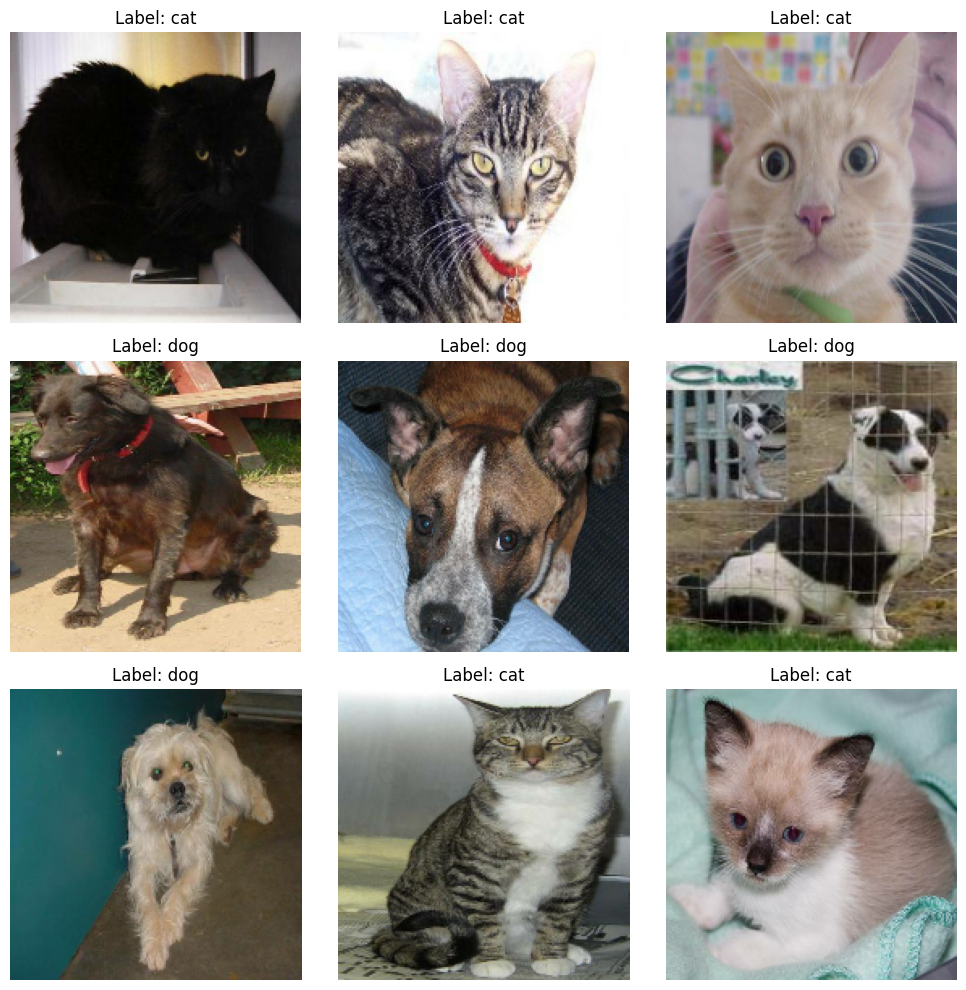

In [21]:
# Define a function to plot different sample images from the dataset
def plot_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 10))

    # Consider a single batch from the dataset 
    for images, labels in dataset.take(1):
        # Loop through the first 9 images in the batch
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))  # Display the image after coverting it to the right format
            plt.title(f'Label: {class_names[int(labels[i])]}') # Set the title of the plot using the class name 
            plt.axis('off') # Hide the axis
    plt.tight_layout()
    plt.show()

class_names = train_dataset.class_names   # Get the class names from the train dataset
plot_sample_images(train_dataset, class_names) # Call the function to plot the sample images from the train dataset


EXPLAIN
As shown, the images vary in pose, background, lighting and quality with different orientations and examples from both cats and dogs. Such diversity strengthens the model's ability to generalize to real-world conditions.

- Explore the distribution of classes ( cats and dogs) in the training dataset

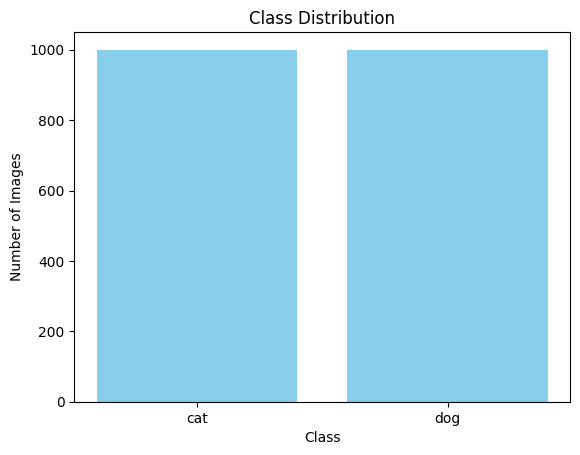

In [22]:
# Define a function to count the number of samples in each of the classes 
def get_label_distribution(dataset):
    label_counts = Counter()
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        label_counts[label] += 1
    return label_counts

# Apply the function on the train dataset
label_dist = get_label_distribution(train_dataset)

# Map the label indices to their labels
label_names = [class_names[k] for k in label_dist.keys()]
label_values = list(label_dist.values())

# Plot the bar chart
plt.bar(label_names, label_values, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

3. Train two networks

3.1 Define a Neural Network of your choice

In [ ]:
# Define the inputs shape for the model: images of size 180x180 with 3 color channels
inputs = keras.Input(shape=(180, 180, 3))
# Normalize pixel values to range [0, 1]
x = layers.Rescaling(1./255)(inputs)
# First convolutional layer: 32 filters of size 3x3 with ReLU activation
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
# Downsample the feature map using max pooling with a 2x2 window 
x = layers.MaxPooling2D(pool_size=2)(x)
# Second convolutional layer: 64 filters
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) # Again, reduce spatial dimensions
# Third convolutional layer: 128 filters
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Fourth convolutional layer: 256 filters
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Fifth convolutional layer: another 256 filters
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
# Flatten the 3D output to 1D before feeding into dense layer
x = layers.Flatten()(x)

# Final output layer with sigmoid activation for binary classification (cat vs dog)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Define the complete model
model = keras.Model(inputs=inputs, outputs=outputs)

Summary 
This is a deep convolutional neural network built for binary image classification. It uses five convolutional layers to extract spatial feaatures. The model ends with a sigmoid-activated dense layer, which outputs a probability for one of the two classes.

In [ ]:
# Display a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Explanation
- Layer (type): Shows the name and type of each layer in the model
- Output Shape: Shape of the data after it passes through the layer
- Param#: Total number of trainable weights (parameters) in the layer.
- Total params: All trainable parameters in the model.
- Trainable/Non-trainable: Parameters that are updated during training

In [ ]:
# Compile the model before training 
model.compile(loss="binary_crossentropy", # Loss function for binary classification (cat vs dog)
              optimizer="rmsprop", # RMSprop optimizer adjusts learning rate dynamically
              metrics=["accuracy"]) # Track accuracy during training and evaluation

In [ ]:
# Define a list of callbacks to apply during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras", # Path to save the best model
        save_best_only=True, # Only save the model if the validation loss improves 
        monitor="val_loss") # Monitor validation loss during training
]
# Train the model 
history = model.fit(
    train_dataset, # Training data 
    epochs=30, # Number of times the model sees the full training data
    validation_data=validation_dataset, # Validation data to monitor overfitting
    callbacks=callbacks) # Apply the ModelCheckpoint callback

Epoch 1/30
63/63 [==============================] - 117s 2s/step - loss: 0.6944 - accuracy: 0.5050 - val_loss: 0.6918 - val_accuracy: 0.5050
Epoch 2/30
63/63 [==============================] - 125s 2s/step - loss: 0.6939 - accuracy: 0.5470 - val_loss: 0.6784 - val_accuracy: 0.5470
Epoch 3/30
63/63 [==============================] - 126s 2s/step - loss: 0.6804 - accuracy: 0.5850 - val_loss: 0.6574 - val_accuracy: 0.6030
Epoch 4/30
63/63 [==============================] - 125s 2s/step - loss: 0.6485 - accuracy: 0.6290 - val_loss: 0.6354 - val_accuracy: 0.6390
Epoch 5/30
63/63 [==============================] - 133s 2s/step - loss: 0.6095 - accuracy: 0.6675 - val_loss: 0.6881 - val_accuracy: 0.5730
Epoch 6/30
63/63 [==============================] - 132s 2s/step - loss: 0.5621 - accuracy: 0.7135 - val_loss: 0.6181 - val_accuracy: 0.6640
Epoch 7/30
63/63 [==============================] - 127s 2s/step - loss: 0.5294 - accuracy: 0.7255 - val_loss: 0.6340 - val_accuracy: 0.6730
Epoch 8/30
63

Displaying Curves of loss and Accuracy during training

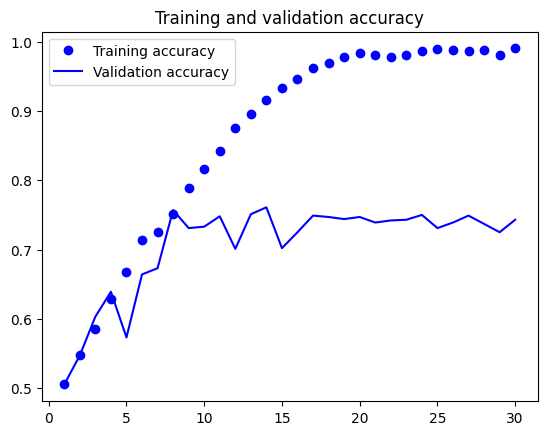

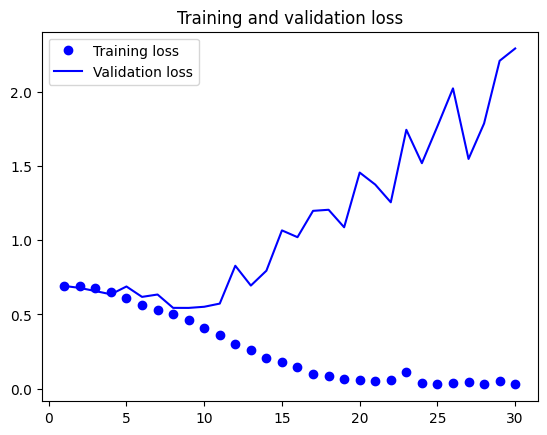

In [ ]:
# Extract training and validation accuracy from the training history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

# Extract training and validation loss from the training history
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Create a list of epoch numbers
epochs = range(1, len(accuracy) + 1)

# Plot Training and Validation Accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

# Plot Training and Validation Loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

# Display both plots
plt.show()

Evaluating the Model on test set

In [ ]:
# Load a pre-trained Keras model saved in the '.keras' format from the specified directory
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")

# Evaluate the model on the 'test_dataset' to compute loss and accuracy
test_loss, test_acc = test_model.evaluate(test_dataset)

# Print the test accuracy formatted to 3 decimal places
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 22s 348ms/step - loss: 0.5676 - accuracy: 0.7205
Test accuracy: 0.720


Using Data Augmentation

In [ ]:
# Define a data augmentation stage to add to an image 

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"), # Randomly flip images horizintally during training (helps with generalization)
        layers.RandomRotation(0.1), # Randomly rotates image by a small factor to stimulate different angles
        layers.RandomZoom(0.2), # Randomly zoom into images up to 20% to stimulate different distances
    ]
)

Summary
This is commonly used in computer vision tasks to artificially increase the diversity of your training data. It's especially helpful when training on smaller datasets, as it helps prevent overfitting by making the model more robust to variation in the input images.

Displaying some randomly augmented training image

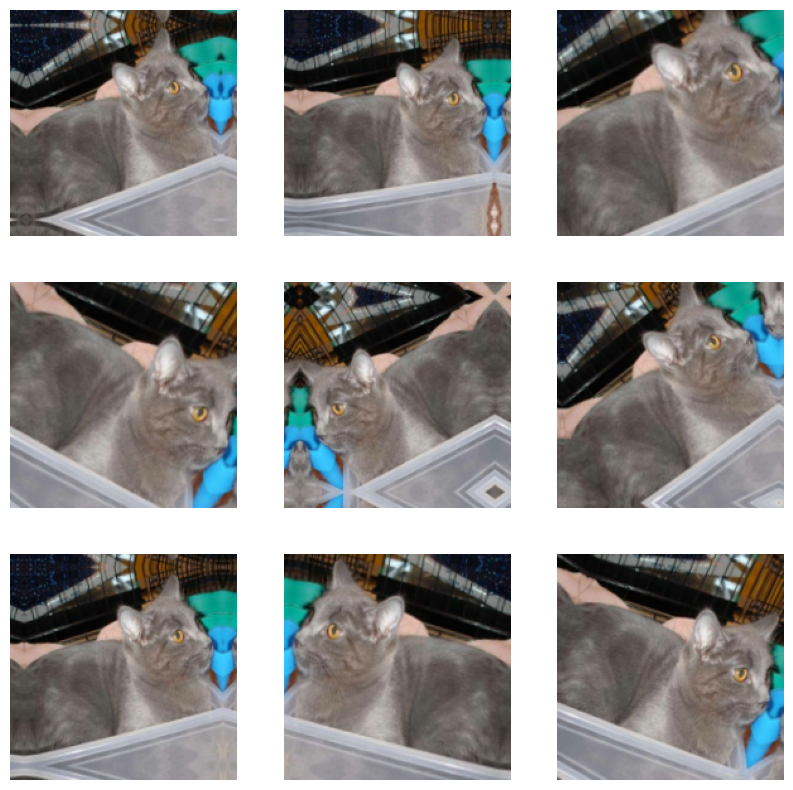

In [ ]:
# Set the size of the entire figure (10x10 inches)
plt.figure(figsize=(10, 10))

# Take a single batch from the training dataset
for images, _ in train_dataset.take(1):
    # Generate and display 9 augmented versions of the first image in the batch
    for i in range(9):
        # Apply the data augmentation pipeline to the batch of images
        augmented_images = data_augmentation(images)
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        # Display the first image from the augmented batch
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        # Hide axis lines and labels for cleaner visualization
        plt.axis("off")

Summary
This code visualizes the result of applying random augmentations to one image multiple times. It helps confirm that the augmentations are working as expected(flip, rotate, zoom). Only the first image of the batch is used (augmented_images[0]). Since the augmentation is random, you see different variations in each subplot.

Defining a new convnet that include image augmentation and dropout

In [ ]:
# Define the input layers for images with shape 180x180 and 3 color channels
inputs = keras.Input(shape=(180, 180, 3))
# Apply data augmentation pipeline (flip, rotate, zoom)
x = data_augmentation(inputs)
# Noramalize pixel values from [0, 255] to [0, 1]
x = layers.Rescaling(1./255)(x)
# First convolutional block; 32 filters, 3x3 kernel, ReLU activation
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Second block: 64 filters
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Third block: 128 filters
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Fourth block: 256 filters
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# Fifth block: another 256 filters 
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
# Dropout to reduce overfitting
x = layers.Dropout(0.5)(x)

# Final output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)
# Define the full model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model the binary cross-entropy loss, RMSProp optimizer, and accuracy metric
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

Training the regularized Convnet

In [ ]:
# Define a list allbacks to use during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True, # Only save the model if the vaidation loss improves
        monitor="val_loss") # Monitor the validation loss during training
]
# Train the model
history = model.fit(
    train_dataset,
    epochs=100, # Number of training Epoch
    validation_data=validation_dataset, # Validation dataset for monitoring generalizatio
    callbacks=callbacks) # Use the defined callbacks

Epoch 1/100
63/63 [==============================] - 141s 2s/step - loss: 0.6953 - accuracy: 0.5090 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 139s 2s/step - loss: 0.6939 - accuracy: 0.5130 - val_loss: 0.6891 - val_accuracy: 0.5080
Epoch 3/100
63/63 [==============================] - 139s 2s/step - loss: 0.6928 - accuracy: 0.5390 - val_loss: 0.6654 - val_accuracy: 0.6030
Epoch 4/100
63/63 [==============================] - 130s 2s/step - loss: 0.6676 - accuracy: 0.5990 - val_loss: 0.6708 - val_accuracy: 0.5620
Epoch 5/100
63/63 [==============================] - 139s 2s/step - loss: 0.6520 - accuracy: 0.6285 - val_loss: 0.6272 - val_accuracy: 0.6490
Epoch 6/100
63/63 [==============================] - 181s 3s/step - loss: 0.6351 - accuracy: 0.6380 - val_loss: 0.6517 - val_accuracy: 0.5970
Epoch 7/100
63/63 [==============================] - 159s 3s/step - loss: 0.6262 - accuracy: 0.6635 - val_loss: 0.6631 - val_accuracy: 0.6290
Epoch 

Evaluating the model on the test set

In [ ]:
# Load the best model saved during training (based on lowest validation loss)
test_model = keras.models.load_model(
    "./models/convnet_from_scratch_with_augmentation.keras")

# Evaluate the model on the test dataset(returns loss and accuracy)
test_loss, test_acc = test_model.evaluate(test_dataset)

# Print the test accuracy rounded to 3 decimal places
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 54s 808ms/step - loss: 0.4768 - accuracy: 0.8460
Test accuracy: 0.846


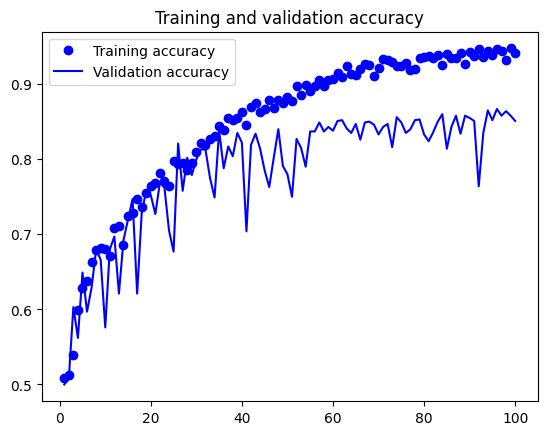

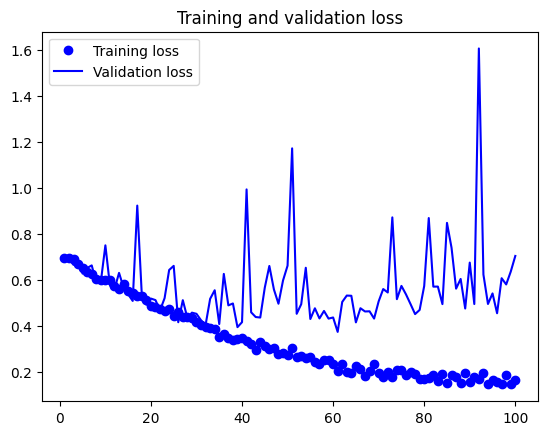

In [ ]:
# Extract accuracy and loss metrics from the training history
accuracy = history.history["accuracy"] # Training accuracy
val_accuracy = history.history["val_accuracy"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

# Define the range of epochs for x-axis
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy 
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure() # Create a new figure for loss plot

# Plot training and validation loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

# Diplay both plots
plt.show()

3.2 Fine-tune VGG16 

Instantiating the VGG16 convolutional base

In [ ]:
# Load the VGG16 model pre-trained on ImageNet, excluding the fully connected (top) layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", # Load weights pre-trained on ImageNet
    include_top=False, # Exclude the fully connected layers at the top
    input_shape=(180, 180, 3)) # Input shape expected for our dataset

58889256/58889256 [==============================] - 6s 0us/step


In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Extracting the VGG16 features and corresponding labels

In [ ]:
# Import pathlib for easy path handling
data_folder = pathlib.Path("../data/kagglecatsanddogs_small_test") # Root data directory

# Load training dataset
train_dataset = image_dataset_from_directory(
    data_folder / "train", # Path to the training data folder
    image_size=(180, 180), # Resize all images to 180x180
    batch_size=32) # Number of images per batch

# Load Validation dataset
validation_dataset = image_dataset_from_directory(
    data_folder / "validation", # Path to the validation data folder
    image_size=(180, 180),
    batch_size=32)

# Load test dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test", # Path to the test data folder
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
def get_features_and_labels(dataset):
    # Initialize empty lists to store features and labels
    all_features = []
    all_labels = []

    # Iterate through the dataset, which yields images and labels
    for images, labels in dataset:
        # Preprocess the images using VGG16's preprocessing function to ensure they are in correct format
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        # Pass the preprocessed images through the convolutional base (conv_base) to extract features
        features = conv_base.predict(preprocessed_images)

        # Append the extracted features and corresponding labels to the lists 
        all_features.append(features)
        all_labels.append(labels)
    # Concatenate the lists of features and corresponding labels arrays into single arrays
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset) # Call the function to get features and labels for the training dataset
val_features, val_labels =  get_features_and_labels(validation_dataset) #  Call the function to get features and labels for the validation dataset
test_features, test_labels =  get_features_and_labels(test_dataset)   # Call the function to get features and labels for the test dataset

1/1 [==============================] - 5s 5s/step


In [42]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier*

In [ ]:
# Define the input layer with a shape of (5, 5, 512) - 5x5 spatial dimensions with 512 dimensions 
inputs = keras.Input(shape=(5, 5, 512))
# Flattens the 5x5x512 input tensor into a 1D array to feed into the dense layer
x = layers.Flatten()(inputs)
# Add a fully connected (dense) layer with 256 units
x = layers.Dense(256)(x)
# Add a dropout layer with a rate of 0.5 to prevent overfitting during training
x = layers.Dropout(0.5)(x)
# Add another dense layer as output layer with 1 unit and sigmoid activation for binary classification 
outputs = layers.Dense(1, activation="sigmoid")(x)
# Create the keras model with the defined inputs and outputs
model = keras.Model(inputs, outputs)

Model Overview: This model is a simple neural network designed for binary classification, where the input tensor has a shape of (5, 5, 512). After flattening the inout, the data passes through a dense layer, a dropoutlayer, and then an output layer with a sigmoid activation to predict probabiliyties for two classes.

In [44]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3277056   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model with binary crossentropy loss, RMSProp optimizer and accuracy as the evaluation metrics
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
# Define the callback to save the best model based on validation loss during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="./models/feature_extraction.keras", # Save the model to this file path
      save_best_only=True, 
      monitor="val_loss")
]
# Train the model with the training data and validation data, using the defined callbacks
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 7s 79ms/step - loss: 23.9645 - accuracy: 0.9140 - val_loss: 6.3467 - val_accuracy: 0.9590
Epoch 2/20
63/63 [==============================] - 5s 74ms/step - loss: 3.3480 - accuracy: 0.9770 - val_loss: 7.2718 - val_accuracy: 0.9600
Epoch 3/20
63/63 [==============================] - 4s 68ms/step - loss: 1.9233 - accuracy: 0.9875 - val_loss: 5.1341 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 4s 69ms/step - loss: 0.8237 - accuracy: 0.9925 - val_loss: 6.8365 - val_accuracy: 0.9660
Epoch 5/20
63/63 [==============================] - 4s 68ms/step - loss: 0.8845 - accuracy: 0.9910 - val_loss: 5.4072 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 4s 69ms/step - loss: 0.9478 - accuracy: 0.9935 - val_loss: 4.6960 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 4s 70ms/step - loss: 0.8065 - accuracy: 0.9940 - val_loss: 14.3548 - val_accuracy: 0.9480
Epoch 8/20


Plotting the Result

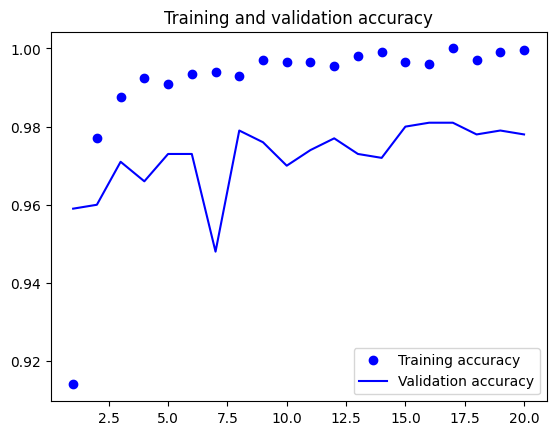

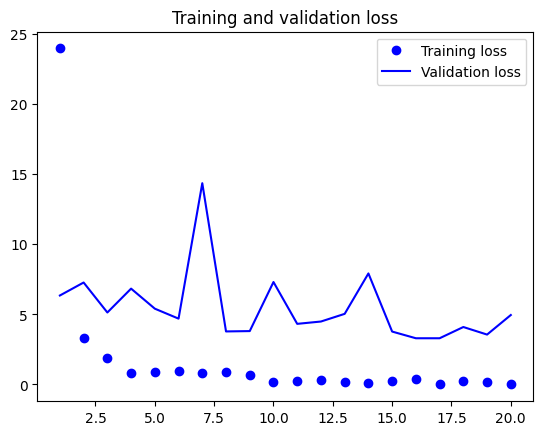

In [ ]:
# Extract accuracy and loss values for training and validation sets from the hoistory object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Create an epoch range from 1 to the number of epochs in the training process 
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
# Create a new figure for loss visualization 
plt.figure()
# Plot training and validation loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
# Show the plots
plt.show()

Summary:
These plots help visualize how well the model is performing during training. Accuracy plot shows how the models accuracy changes over time for both the training and validation sets. This helps track if the model is overfitting. The loss plot shows how the loss function value decreases over time, indicating how well the model is minimizing the error on both the training and validation data.

In [47]:
test_model = keras.models.load_model(
    "./models/feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(x=test_features, y=test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 8ms/step - loss: 5.3718 - accuracy: 0.9730
Test accuracy: 0.973


Instantiating and freezing the VGG16 convolutional base

In [48]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [49]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Printing the list of trainable weights before and after freezing

In [50]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [51]:
# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [52]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                           

In [ ]:
# Compile the model with binary crossentropy loss, RMSProp optimizer and accuracy as the evaluation metric
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define the callback 
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 747s 12s/step - loss: 21.3390 - accuracy: 0.8990 - val_loss: 5.6400 - val_accuracy: 0.9660
Epoch 2/50
63/63 [==============================] - 702s 11s/step - loss: 6.3044 - accuracy: 0.9505 - val_loss: 3.9495 - val_accuracy: 0.9800
Epoch 3/50
63/63 [==============================] - 792s 13s/step - loss: 7.6135 - accuracy: 0.9505 - val_loss: 2.9364 - val_accuracy: 0.9800
Epoch 4/50
63/63 [==============================] - 745s 12s/step - loss: 5.1213 - accuracy: 0.9605 - val_loss: 3.5449 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 774s 12s/step - loss: 5.0272 - accuracy: 0.9600 - val_loss: 4.6779 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 762s 12s/step - loss: 3.7453 - accuracy: 0.9670 - val_loss: 5.5414 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 666s 11s/step - loss: 3.1675 - accuracy: 0.9655 - val_loss: 3.8237 - val_accuracy: 0.9780
Epoch

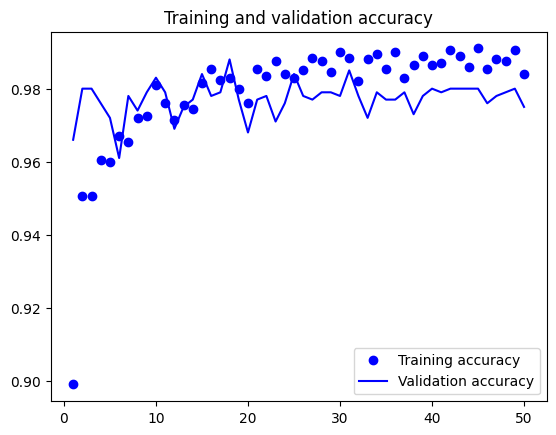

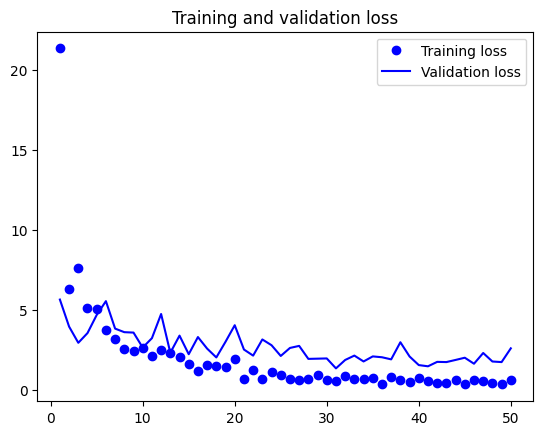

In [ ]:
# Extract accuracy and loss values for training and validation set
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Create an epoch range from 1 to the number of epochs in the traning process
epochs = range(1, len(acc) + 1)

# Plot training and Validation accuracy
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the Model Test Set

In [55]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 730s 12s/step - loss: 2.3906 - accuracy: 0.9750
Test accuracy: 0.975


Fine Tuning a PreTrained Model

In [56]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freezing all layers until the fourth of the last

In [57]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [58]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                           

Fine Tuning the Model

In [ ]:
# Compile the model with binary crossentropy loss, RMSProp optimizer and accuracy as the evaluation metric
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 1087s 17s/step - loss: 0.4680 - accuracy: 0.9870 - val_loss: 1.9971 - val_accuracy: 0.9810
Epoch 2/30
63/63 [==============================] - 925s 15s/step - loss: 0.4335 - accuracy: 0.9900 - val_loss: 2.5608 - val_accuracy: 0.9740
Epoch 3/30
63/63 [==============================] - 851s 14s/step - loss: 0.2935 - accuracy: 0.9895 - val_loss: 1.8042 - val_accuracy: 0.9730
Epoch 4/30
63/63 [==============================] - 956s 15s/step - loss: 0.3839 - accuracy: 0.9920 - val_loss: 1.5234 - val_accuracy: 0.9750
Epoch 5/30
63/63 [==============================] - 899s 14s/step - loss: 0.2115 - accuracy: 0.9950 - val_loss: 1.7288 - val_accuracy: 0.9770
Epoch 6/30
63/63 [==============================] - 917s 15s/step - loss: 0.3100 - accuracy: 0.9925 - val_loss: 1.5770 - val_accuracy: 0.9740
Epoch 7/30
63/63 [==============================] - 914s 15s/step - loss: 0.3833 - accuracy: 0.9915 - val_loss: 1.4744 - val_accuracy: 0.9800
Epoch

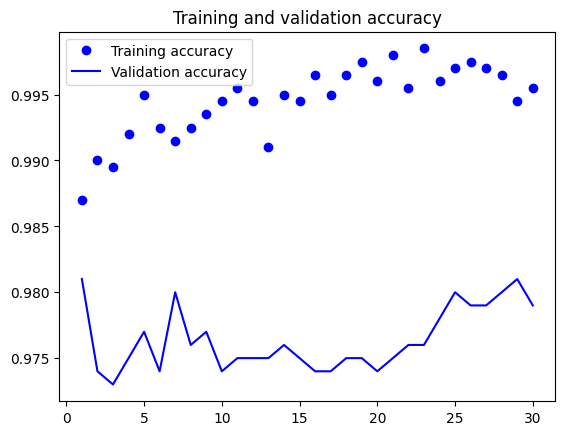

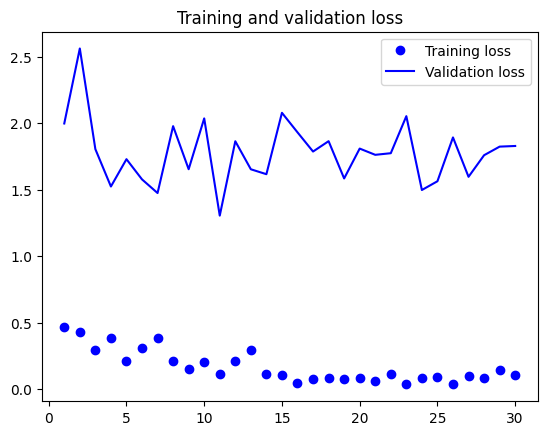

In [ ]:
# Extract accuracy and loss values for training and validation set
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Create an epoch range from 1 to the number of epochs in the traning process
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [61]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 488s 8s/step - loss: 1.7594 - accuracy: 0.9755
Test accuracy: 0.975


In [63]:
# Get model predictions
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)


63/63 [==============================] - 542s 9s/step


In [64]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("confusion_matrix:\n", cm)

confusion_matrix:
 [[1000    0]
 [1000    0]]


In [65]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      1.00      0.67      1000
         Dog       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



c:\Users\henry o\Downloads\CSCN8010\venv\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry o\Downloads\CSCN8010\venv\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\henry o\Downloads\CSCN8010\venv\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

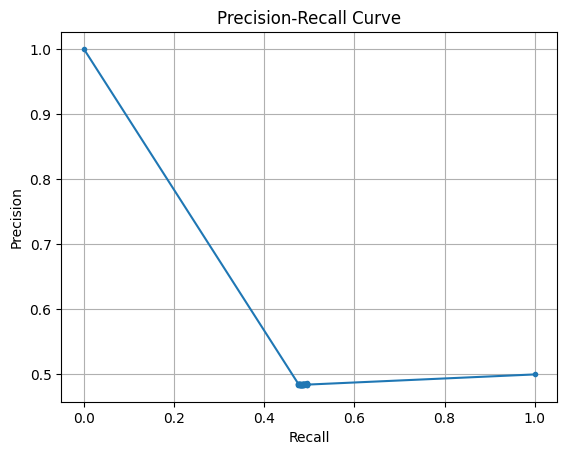

In [70]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 0])
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

Failure Example

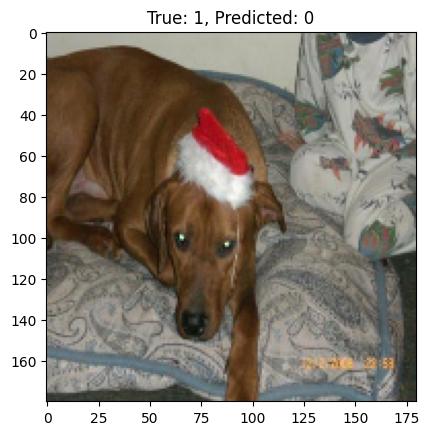

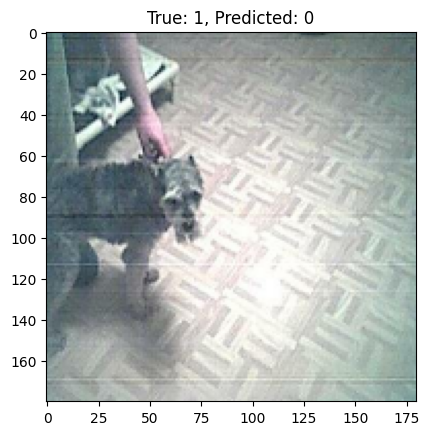

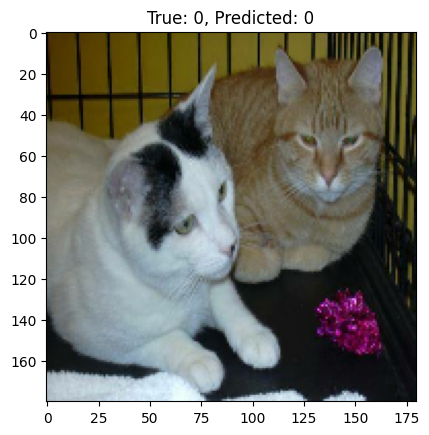

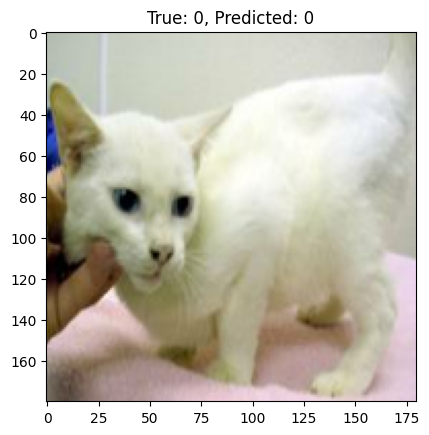

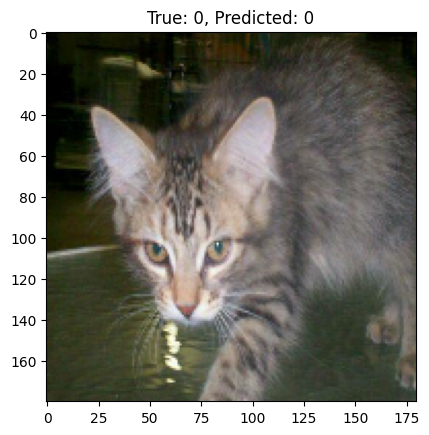

In [71]:
misclassified_indices = np.where(y_pred != y_true)[0]

# Visualizing some misclassified image
for i in misclassified_indices[:5]:
    image, label = list(test_dataset.unbatch())[i]
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(f'True: {label}, Predicted: {y_pred[i]}')
    plt.show()

CONCLUSION

This project implemented several convolutional neural network (CNN) models for classifying cats and dogs using the Kaggle dataset. It went through stages of baseline training, Data augmentation, feature extraction using VGG16, Fine-tuning the pretrained model and the accuracy improced incrementally. The evaluation was performed using accuracy as well as detailed metrics like the confusion matrix, precision, recall, F1-score and the precision-recall curve. The final model, especially the fine-tuned VGG16 showed strong performance. But while the fine-tuned VGG16 model achieved good results, there remains room for improvement through more sophisticated architectures, larger datasets and advanced techniques like self-surpervised pretraining. However, the 90% + accuracy demonstrates that even with limited data and simple fine-tuning, deep learning can solve real-world image classification problems effectively.